REGRESSION

In [1]:
#A bunch of libraries and packages 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xlrd

from sklearn import linear_model
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_excel('CX2_16_1_30_12.xlsx',sheet_name='Channel_1-006')
df.head()

,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000283,2012-01-12 15:54:08,30.000284,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
1,2,60.015499,2012-01-12 15:54:38,60.015500,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
2,3,90.030861,2012-01-12 15:55:08,90.030861,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
3,4,120.014716,2012-01-12 15:55:38,120.014716,1,1,0.0,4.117773,0.000000,0.0,0.000000,0.0,0.0,0.0,0,0,0
4,5,150.171587,2012-01-12 15:56:08,30.015424,3,1,0.0,4.117935,0.000026,0.0,0.000108,0.0,0.0,0.0,0,0,0


In [3]:
group = df.groupby(['Cycle_Index']).count()
group.head()
group['Cumu_count'] = pd.Series(np.random.randn(len(group)), index=group.index)
group['Cumu_count'] = group['Data_Point'].cumsum()

In [4]:
df['Charge'] = pd.Series(np.random.randn(len(df)), index=df.index)
df['discharge'] = pd.Series(np.random.randn(len(df)), index=df.index)
cycle = []
cycle = group['Cumu_count']
df['Charge'][0:cycle[1]] = df['Charge_Capacity(Ah)'][0:cycle[1]]
df['discharge'][0:cycle[1]] = df['Discharge_Capacity(Ah)'][0:cycle[1]]

/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
# Converting cumulative charge capacity data to individual cycle data.
for i in range(1,len(cycle)):
    df['Charge'][cycle[i]:cycle[i+1]] = df['Charge_Capacity(Ah)'][cycle[i]:cycle[i+1]]-df['Charge_Capacity(Ah)'][cycle[i]]
    df['discharge'][cycle[i]:cycle[i+1]] = df['Discharge_Capacity(Ah)'][cycle[i]:cycle[i+1]]-df['Discharge_Capacity(Ah)'][cycle[i]]

/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shrilakshmisbonageri/miniconda3/envs/keras/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [7]:
# Dropping additional columns 
cycle_data = df.drop(['Data_Point','Internal_Resistance(Ohm)','Step_Index','Step_Time(s)','Cycle_Index','Charge_Capacity(Ah)','Discharge_Capacity(Ah)','Charge_Energy(Wh)','Discharge_Energy(Wh)','dV/dt(V/s)','Is_FC_Data','AC_Impedance(Ohm)','ACI_Phase_Angle(Deg)'],axis=1)
cycle_data['Capacity'] = pd.Series(np.random.randn(len(cycle_data)), index=cycle_data.index)
# Combining charge and discharge capacities to calculate net charge capacity of the battery.
cycle_data['Capacity'] = cycle_data['Charge'] - cycle_data['discharge']
cycle_data.set_index('Date_Time',inplace=True)

In [8]:
# Dataframe for testing and training.
model_data = cycle_data.drop(['Charge','discharge','Test_Time(s)'],axis=1)

In [9]:
model_data.head()

,Current(A),Voltage(V),Capacity
Date_Time,,,
2012-01-12 15:54:08,0.0,4.117773,0.000000
2012-01-12 15:54:38,0.0,4.117773,0.000000
2012-01-12 15:55:08,0.0,4.117773,0.000000
2012-01-12 15:55:38,0.0,4.117773,0.000000
2012-01-12 15:56:08,0.0,4.117935,0.000026


In [15]:
# Splitting the data into training and testing data sets.
train,test = train_test_split(model_data, test_size=0.20, random_state=1010)

Train error 0.027725179811882533
Test error 0.02786636930014584


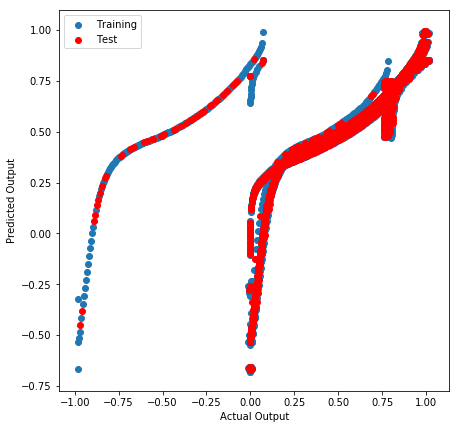

In [18]:
Y = 2
MLR=linear_model.LinearRegression()
MLR.fit(train[train.columns.values[0:2]],train[train.columns.values[Y]])

# make predictions on test and train set 
trainpred=MLR.predict(train[train.columns.values[0:2]])
testpred=MLR.predict(test[train.columns.values[0:2]])

#make parity plot 
plt.figure(figsize=(7,7))
plt.scatter(train[train.columns.values[Y]],trainpred, label='Training')
plt.scatter(test[train.columns.values[Y]],testpred,color='r', label='Test')
plt.plot(lw=4,color='black')
plt.legend()
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')

#calculate the test and train error
print("Train error",mean_squared_error(train[train.columns.values[Y]],trainpred))
print("Test error",mean_squared_error(test[train.columns.values[Y]],testpred))